In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import xgboost as xgb

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', 1000)
pd.set_option('max_rows',40)
pd.set_option('max_columns',1000)

import seaborn as sns 
sns.set_style('darkgrid')

In [2]:
data = pd.read_csv("../input/loan-prediction-analytics-vidhya/train_ctrUa4K.csv")
test = pd.read_csv("../input/loan-prediction-analytics-vidhya/test_lAUu6dG.csv")

# Target

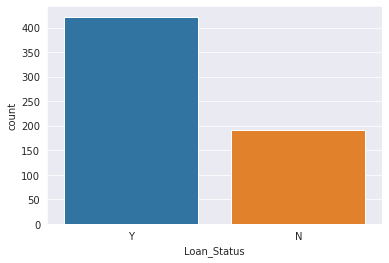

In [3]:
sns.countplot(x="Loan_Status", data=data)

**Numeric Columns**<br>
**Categorical Columns**<br>

In [4]:
num_cols = data.select_dtypes(exclude='object').copy()
cat_cols = data.select_dtypes(include='object').copy()
cat_cols = cat_cols.drop('Loan_ID',axis=1)

In [5]:
num_cols.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


In [6]:
cat_cols.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y


# Uni-variate Analysis

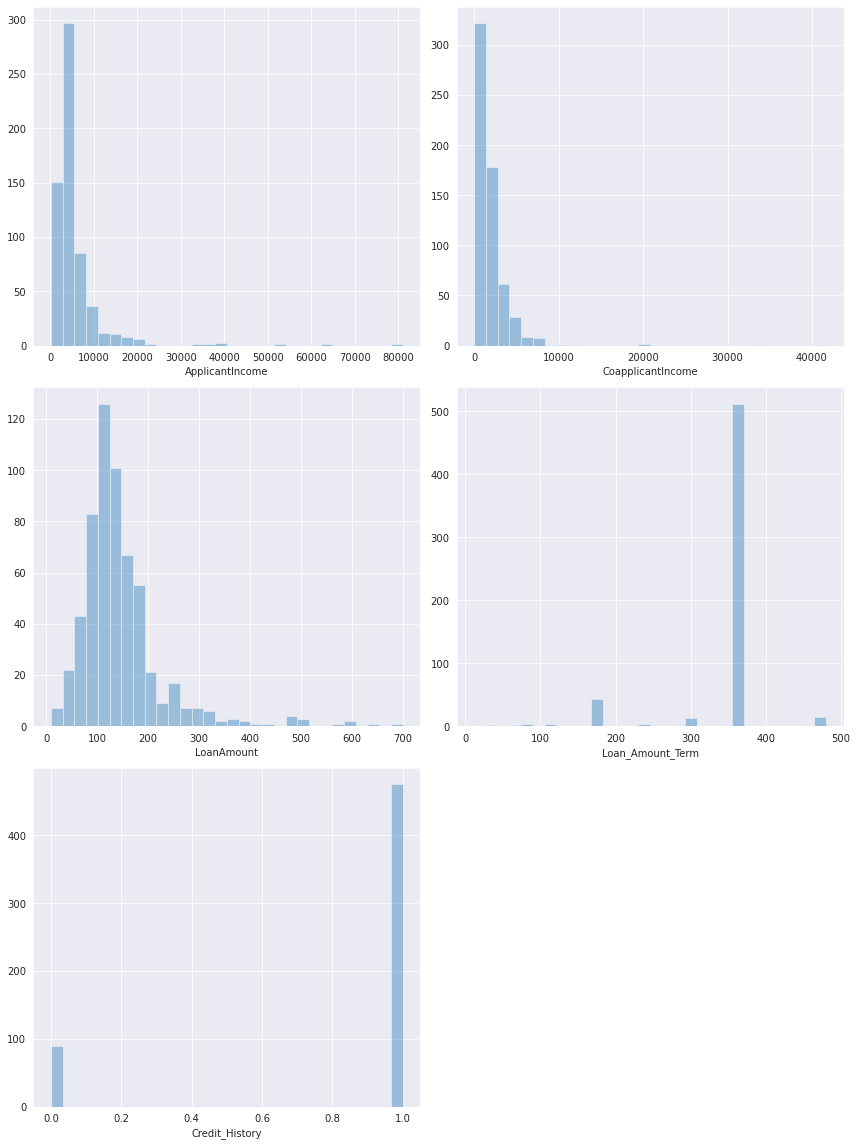

In [7]:
fig = plt.figure(figsize=(12,16))
for index,col in enumerate(num_cols):
    plt.subplot(3,2,index+1)
    sns.distplot(num_cols.loc[:,col].dropna(),kde=False,bins=30)
fig.tight_layout(pad=1.0)

In [8]:
data['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

## Outliers

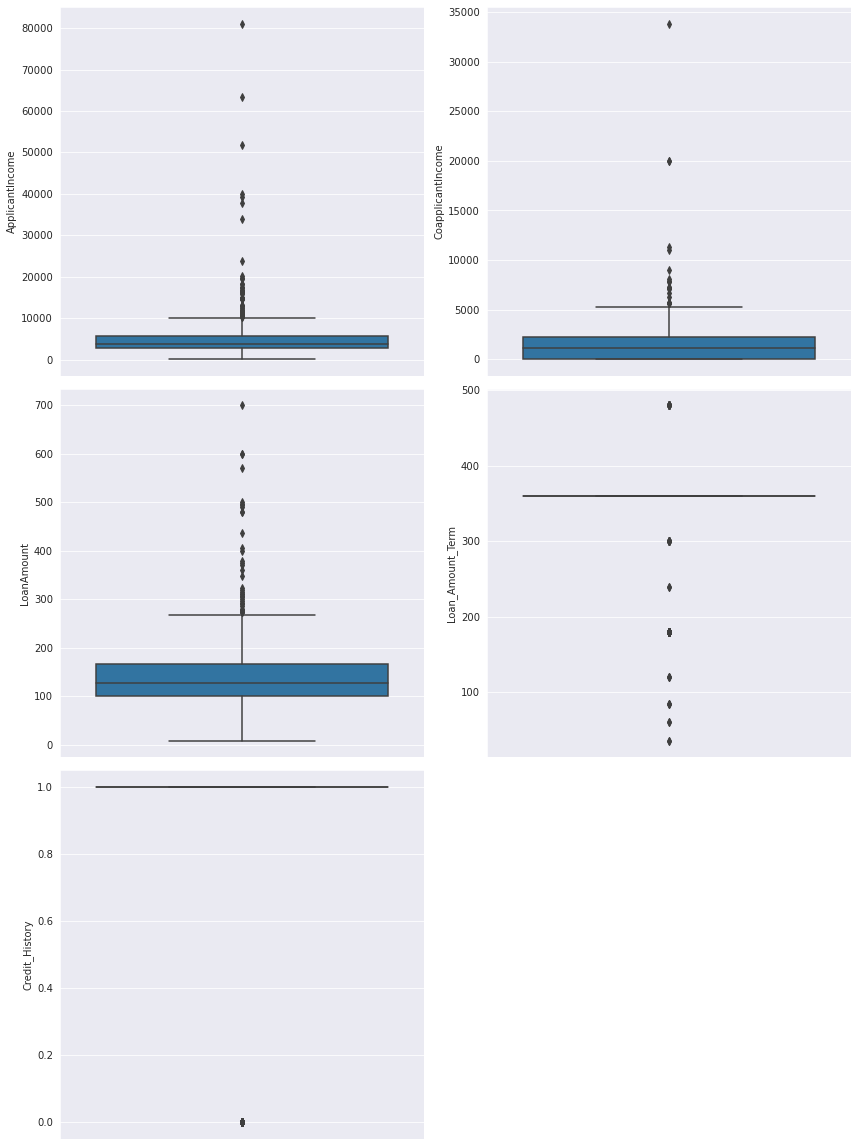

In [9]:
fig = plt.figure(figsize=(12,16))
for index,col in enumerate(num_cols):
    plt.subplot(3,2,index+1)
    sns.boxplot(data=num_cols.dropna(), y=col)
fig.tight_layout(pad=1.0)

## Cat_columns

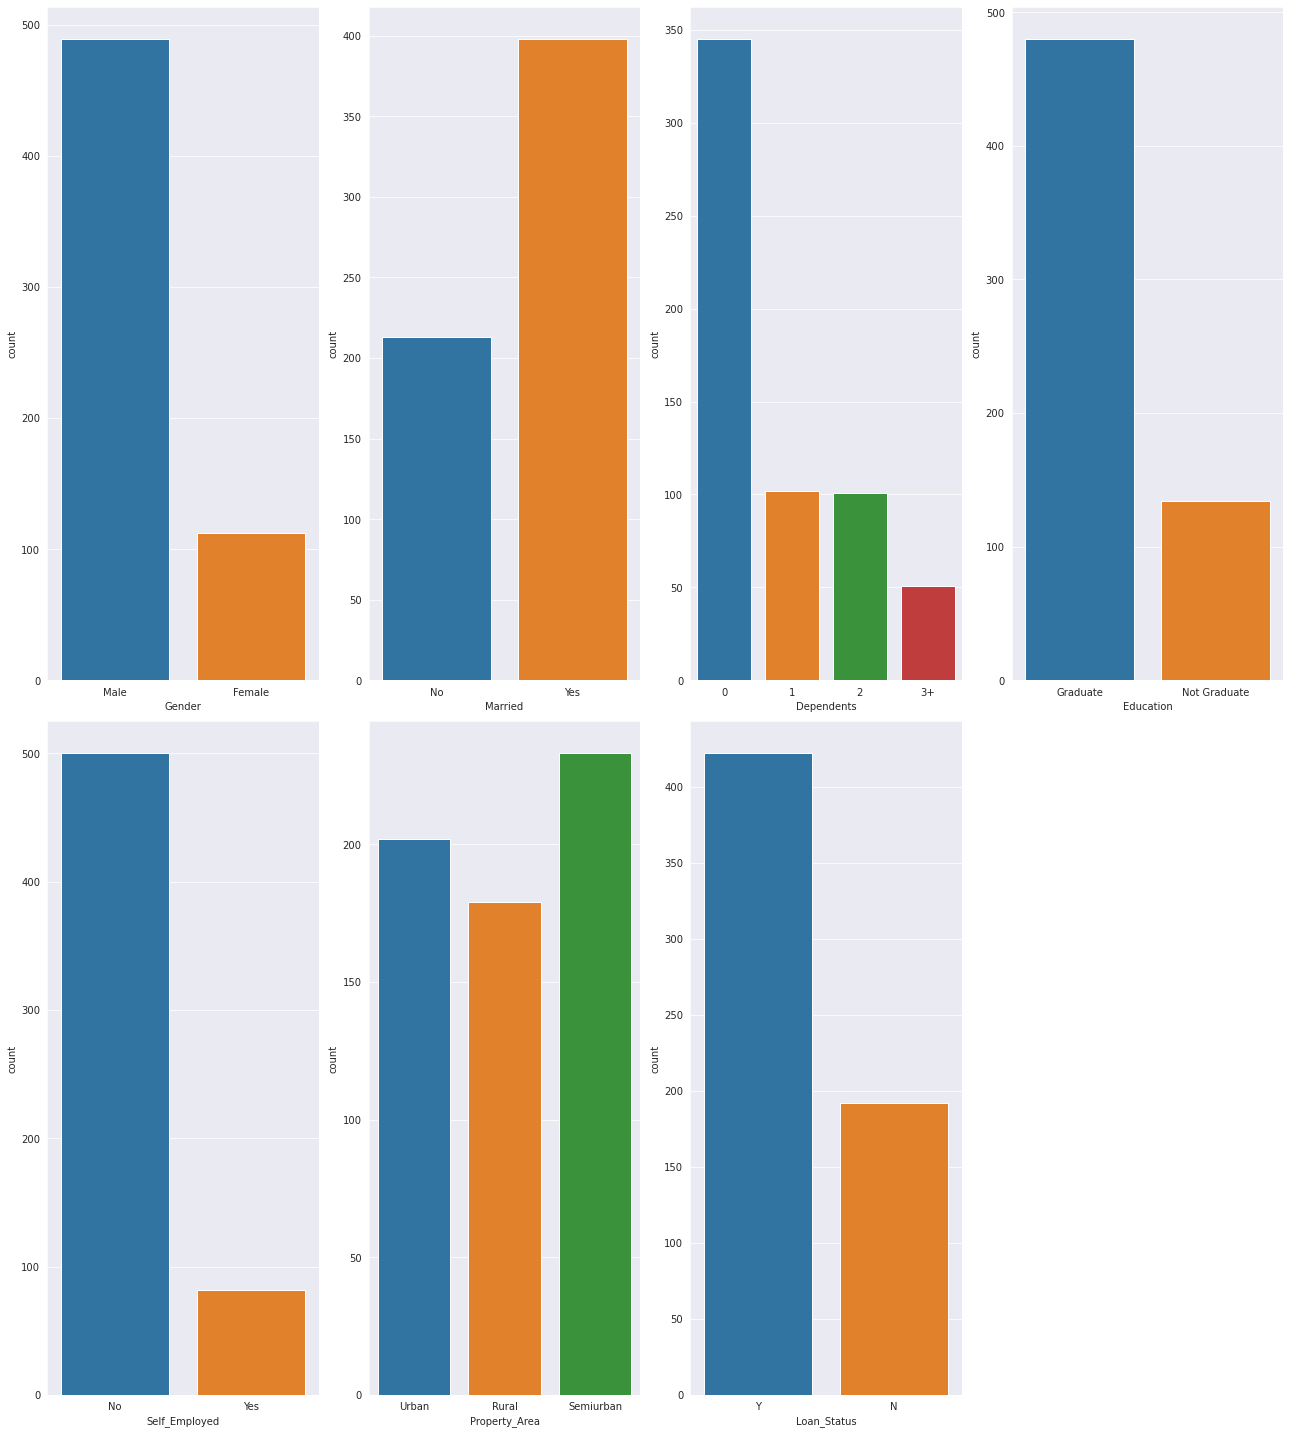

In [10]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_cols.columns)):
    plt.subplot(2,4,index+1)
    sns.countplot(x=cat_cols.iloc[:,index], data=cat_cols.dropna())
#    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

## Missing Values

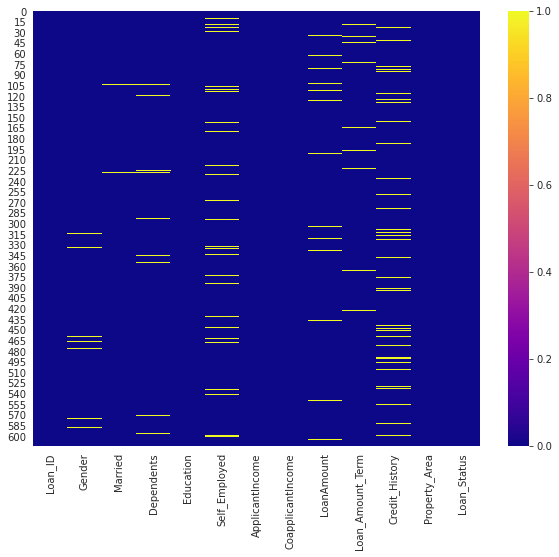

In [11]:
# Checking Null values  
plt.figure(figsize=(10,8))
sns.heatmap(data.isnull(),cmap='plasma')

def percent_missing(d):
    percentage = pd.DataFrame(100*(d.isnull().sum()/len(d)),columns=['Missing_%']).sort_values('Missing_%',ascending=False)
    return (percentage.head(10))

In [12]:
percent_missing(data)

,Missing_%
Credit_History,8.143322
Self_Employed,5.211726
LoanAmount,3.583062
Dependents,2.442997
Loan_Amount_Term,2.280130
Gender,2.117264
Married,0.488599
Loan_ID,0.000000
Education,0.000000
ApplicantIncome,0.000000


In [13]:
#Mapp the Y/N to 1/0
mapp = {'Y':1,'N':0}
data["Loan_Status"] = data["Loan_Status"].map(mapp)

## Correlations

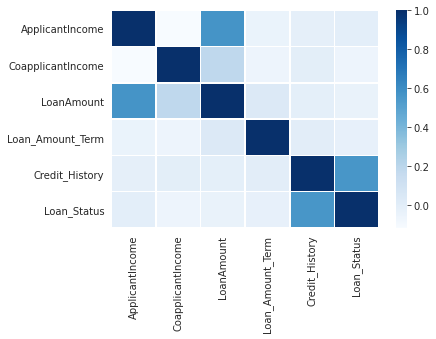

In [14]:
corr = data.corr()
sns.heatmap(data=corr.dropna(),cmap='Blues',linewidth=0.5)

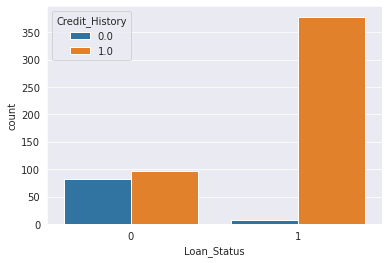

In [15]:
sns.countplot(x='Loan_Status',data=data,hue='Credit_History')

In [16]:
corr["Loan_Status"]

ApplicantIncome     -0.004710
CoapplicantIncome   -0.059187
LoanAmount          -0.037318
Loan_Amount_Term    -0.021268
Credit_History       0.561678
Loan_Status          1.000000
Name: Loan_Status, dtype: float64

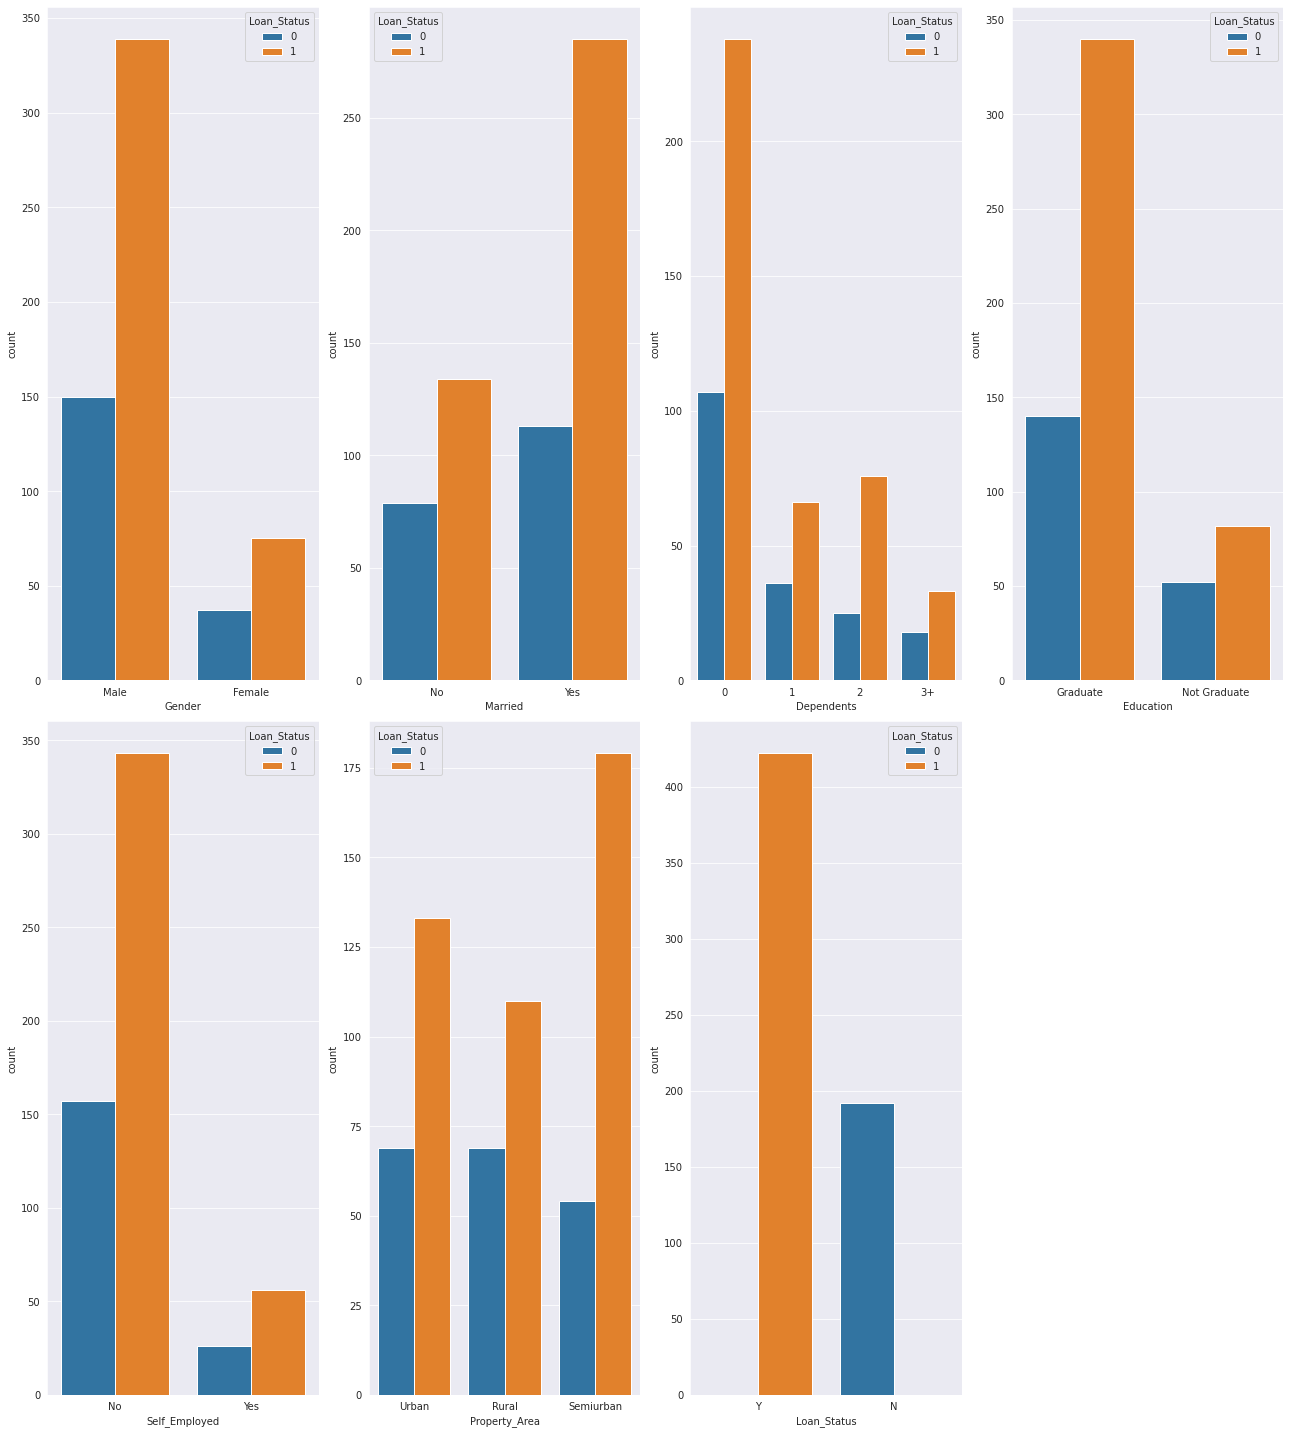

In [17]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_cols.columns)):
    plt.subplot(2,4,index+1)
    sns.countplot(x=cat_cols.iloc[:,index], data=cat_cols.dropna(),hue=data['Loan_Status'])
#    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

# Data Processing 

**Outliers**

In [18]:
data = data[data['ApplicantIncome'] < 50000]
data = data[data['LoanAmount'] < 500]

**Mapping**

In [19]:
mapp_gender = {'Male':0,'Female':1}
mapp_married = {'No':0,'Yes':1}
mapp_dep = {'0':0,'1':1,'2':1,'3+':1}
mapp_edu = {'Not Graduate':0,'Graduate':1}
mapp_se = {'No':0,'Yes':1}
mapp_pa = {'Semiurban':1,'Urban':2,'Rural':3}


data['Gender'] = data['Gender'].map(mapp_gender)
data['Married'] = data['Married'].map(mapp_married)
data['Dependents'] = data['Dependents'].map(mapp_dep)
data['Education'] = data['Education'].map(mapp_edu)
data['Self_Employed'] = data['Self_Employed'].map(mapp_se)
data['Property_Area'] = data['Property_Area'].map(mapp_pa)


test['Gender'] = test['Gender'].map(mapp_gender)
test['Married'] = test['Married'].map(mapp_married)
test['Dependents'] = test['Dependents'].map(mapp_dep)
test['Education'] = test['Education'].map(mapp_edu)
test['Self_Employed'] = test['Self_Employed'].map(mapp_se)
test['Property_Area'] = test['Property_Area'].map(mapp_pa)

mapp_lt = {360.0 :1,180.0 : 0,480.0:0,300.0:0,84.0: 0,240.0: 0,120.0: 0,36.0: 0,60.0: 0,12.0:0}
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].map(mapp_lt)
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].map(mapp_lt)

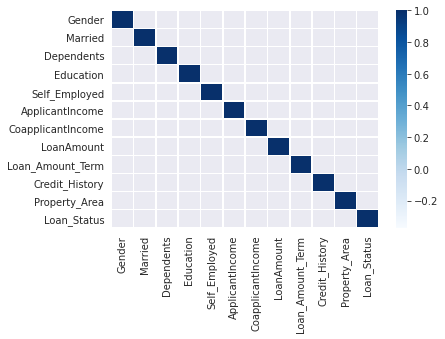

In [20]:
corr = data.corr()
sns.heatmap(data=corr.dropna(),mask = corr < 0.8,cmap='Blues',linewidth=0.5)

No Collinearity btw other features

# Filling Missing Values

In [21]:
loan_amt_avg = test.groupby('ApplicantIncome').mean()['LoanAmount']
def fill_loan_amt(LoanAmount,ApplicantIncome):
    if np.isnan(LoanAmount):
        return loan_amt_avg[ApplicantIncome]
    else:
        return LoanAmount
test['LoanAmount'] = test.apply(lambda x: fill_loan_amt(x['LoanAmount'], x['ApplicantIncome']), axis=1)
test['LoanAmount'] = test['LoanAmount'].fillna(136.9586777)

In [22]:
loan_amt_avg = data.groupby('ApplicantIncome').mean()['LoanAmount']

def fill_loan_amt(LoanAmount,ApplicantIncome):
    if np.isnan(LoanAmount):
        return loan_amt_avg[ApplicantIncome]
    else:
        return LoanAmount
data['LoanAmount'] = data.apply(lambda x: fill_loan_amt(x['LoanAmount'], x['ApplicantIncome']), axis=1)
data['LoanAmount'] = data['LoanAmount'].fillna(146.4121622)

In [23]:
test['Dependents'] = test['Dependents'].fillna(1)
data['Dependents'] = data['Dependents'].fillna(1)

In [24]:
def fill_gender(Gender,Married):
    if np.isnan(Gender):
        if Married ==1:
            return (1)
        else:
            return (0)
    else:
        return Gender
test['Gender'] = test.apply(lambda x: fill_gender(x['Gender'], x['Married']), axis=1)
data['Gender'] = data.apply(lambda x: fill_gender(x['Gender'], x['Married']), axis=1)

In [25]:
def fill_self_emp(Self_Employed,ApplicantIncome):
    if np.isnan(Self_Employed):
        if ApplicantIncome >=7380:
            return (1)
        else:
            return (0)
    else:
        return Self_Employed
test['Self_Employed'] = test.apply(lambda x: fill_self_emp(x['Self_Employed'], x['ApplicantIncome']), axis=1)
data['Self_Employed'] = data.apply(lambda x: fill_self_emp(x['Self_Employed'], x['ApplicantIncome']), axis=1)

In [26]:
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].fillna(0)
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(0)

In [27]:
test['Credit_History'] = test['Credit_History'].fillna(-999)
data = data.dropna()

In [28]:
def fill_CoapplicantIncome(CoapplicantIncome):
    if CoapplicantIncome ==0:
         return (1)
    else:
        return (0)
data['CoapplicantIncome'] = data.apply(lambda x: fill_CoapplicantIncome(x['CoapplicantIncome']), axis=1)
test['CoapplicantIncome'] = test.apply(lambda x: fill_CoapplicantIncome(x['CoapplicantIncome']), axis=1)

In [29]:
mapp = {1:'Y',0:'N'}
data["Loan_Status"] = data["Loan_Status"].map(mapp)

X_train = data.drop(['Loan_ID','Loan_Status'],axis=1)
y_train = data['Loan_Status']

# HyperParameter Tuning

In [30]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 350, 1000),
        'max_depth': trial.suggest_int('max_depth', 6, 13),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.009, 0.10),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_int('gamma', 0, 0.05),
        'missing': -999,
        #'scale_pos_weight': 0.48,
       }
        
    clf = xgb.XGBClassifier(**params)
    auccuracies = []
    X_train_k = X_train.values
    y_train_k = y_train.values
    kf = KFold(n_splits=3,random_state=2000,shuffle=True)
    for train_idx, valid_idx in kf.split(X_train_k,y_train_k):
#        X_train_k, X_test = X_train[train_index], X_train[test_index]
#        y_train_k, y_test = y_train[train_index], y_train[test_index]
        train_data = X_train_k[train_idx, :], y_train_k[train_idx]
        valid_data = X_train_k[valid_idx, :], y_train_k[valid_idx]
        
        clf.fit(X_train_k[train_idx, :], y_train_k[train_idx])
        pred = clf.predict(X_train_k[valid_idx, :])
        accuracy = accuracy_score(y_train_k[valid_idx],pred)
        auccuracies.append(accuracy)
    print(f'Trial done: Accuracy values on folds: {auccuracies}')
    return np.average(auccuracies)

In [31]:
n_trials = 100

FIT_XGB = True

if FIT_XGB:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2020-12-30 03:40:03,086] A new study created in memory with name: no-name-ae2f6fae-e163-45c3-8194-62d5bd2eca6e
[I 2020-12-30 03:40:03,702] Trial 0 finished with value: 0.7883895131086143 and parameters: {'n_estimators': 620, 'max_depth': 7, 'learning_rate': 0.040393975441622876, 'subsample': 0.7407396746249401, 'colsample_bytree': 0.6430874826526302, 'gamma': 0}. Best is trial 0 with value: 0.7883895131086143.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7752808988764045, 0.8258426966292135]


[I 2020-12-30 03:40:04,382] Trial 1 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 671, 'max_depth': 11, 'learning_rate': 0.08225499841531374, 'subsample': 0.999563380078536, 'colsample_bytree': 0.7452627723027833, 'gamma': 0}. Best is trial 0 with value: 0.7883895131086143.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7696629213483146, 0.8146067415730337]


[I 2020-12-30 03:40:05,094] Trial 2 finished with value: 0.7827715355805244 and parameters: {'n_estimators': 740, 'max_depth': 12, 'learning_rate': 0.08250782184315132, 'subsample': 0.9544117610052496, 'colsample_bytree': 0.7554997799474263, 'gamma': 0}. Best is trial 0 with value: 0.7883895131086143.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7696629213483146, 0.8033707865168539]


[I 2020-12-30 03:40:05,786] Trial 3 finished with value: 0.7752808988764045 and parameters: {'n_estimators': 640, 'max_depth': 9, 'learning_rate': 0.05169523837721171, 'subsample': 0.5183580390988299, 'colsample_bytree': 0.6119872255266323, 'gamma': 0}. Best is trial 0 with value: 0.7883895131086143.


Trial done: Accuracy values on folds: [0.7471910112359551, 0.7584269662921348, 0.8202247191011236]


[I 2020-12-30 03:40:07,116] Trial 4 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 882, 'max_depth': 9, 'learning_rate': 0.08663246320040599, 'subsample': 0.9821942775202566, 'colsample_bytree': 0.8751646878941305, 'gamma': 0}. Best is trial 0 with value: 0.7883895131086143.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7584269662921348, 0.8146067415730337]


[I 2020-12-30 03:40:07,671] Trial 5 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 414, 'max_depth': 11, 'learning_rate': 0.09100288656917015, 'subsample': 0.9219224066648819, 'colsample_bytree': 0.9620134139393617, 'gamma': 0}. Best is trial 0 with value: 0.7883895131086143.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7584269662921348, 0.8146067415730337]


[I 2020-12-30 03:40:08,549] Trial 6 finished with value: 0.7827715355805244 and parameters: {'n_estimators': 930, 'max_depth': 7, 'learning_rate': 0.03349442970660465, 'subsample': 0.6674707373999094, 'colsample_bytree': 0.7234585534618764, 'gamma': 0}. Best is trial 0 with value: 0.7883895131086143.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7640449438202247, 0.8258426966292135]


[I 2020-12-30 03:40:10,569] Trial 7 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.040428865426493564, 'subsample': 0.533999564942955, 'colsample_bytree': 0.8030621321003781, 'gamma': 0}. Best is trial 0 with value: 0.7883895131086143.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7696629213483146, 0.8146067415730337]


[I 2020-12-30 03:40:11,049] Trial 8 finished with value: 0.7715355805243446 and parameters: {'n_estimators': 539, 'max_depth': 9, 'learning_rate': 0.08037696009518777, 'subsample': 0.6508467188697601, 'colsample_bytree': 0.5106441534960224, 'gamma': 0}. Best is trial 0 with value: 0.7883895131086143.


Trial done: Accuracy values on folds: [0.7303370786516854, 0.7640449438202247, 0.8202247191011236]


[I 2020-12-30 03:40:11,695] Trial 9 finished with value: 0.797752808988764 and parameters: {'n_estimators': 450, 'max_depth': 12, 'learning_rate': 0.013947629562148713, 'subsample': 0.7640175304665406, 'colsample_bytree': 0.8667168842732009, 'gamma': 0}. Best is trial 9 with value: 0.797752808988764.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7752808988764045, 0.8370786516853933]


[I 2020-12-30 03:40:12,224] Trial 10 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 365, 'max_depth': 13, 'learning_rate': 0.009026529965108655, 'subsample': 0.8452864098052733, 'colsample_bytree': 0.9825189148755136, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7865168539325843, 0.8426966292134831]


[I 2020-12-30 03:40:12,728] Trial 11 finished with value: 0.801498127340824 and parameters: {'n_estimators': 354, 'max_depth': 13, 'learning_rate': 0.009333367062952954, 'subsample': 0.8443799157832019, 'colsample_bytree': 0.9580282091608975, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7921348314606742, 0.8314606741573034]


[I 2020-12-30 03:40:13,236] Trial 12 finished with value: 0.801498127340824 and parameters: {'n_estimators': 350, 'max_depth': 13, 'learning_rate': 0.012308227209969078, 'subsample': 0.8660956331232204, 'colsample_bytree': 0.993135276818541, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8370786516853933]


[I 2020-12-30 03:40:13,782] Trial 13 finished with value: 0.7883895131086143 and parameters: {'n_estimators': 366, 'max_depth': 13, 'learning_rate': 0.02130814233292495, 'subsample': 0.8405388443446983, 'colsample_bytree': 0.9284752644763984, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7640449438202247, 0.8202247191011236]


[I 2020-12-30 03:40:14,602] Trial 14 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 498, 'max_depth': 13, 'learning_rate': 0.02244095861479623, 'subsample': 0.8348805749604029, 'colsample_bytree': 0.9975149620631057, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7640449438202247, 0.8146067415730337]


[I 2020-12-30 03:40:15,394] Trial 15 finished with value: 0.7771535580524344 and parameters: {'n_estimators': 784, 'max_depth': 11, 'learning_rate': 0.06573677088935656, 'subsample': 0.7720202152945904, 'colsample_bytree': 0.9116984024696743, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7640449438202247, 0.8033707865168539]


[I 2020-12-30 03:40:16,203] Trial 16 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 549, 'max_depth': 12, 'learning_rate': 0.009705797417348781, 'subsample': 0.89460659980224, 'colsample_bytree': 0.8299955317259561, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.797752808988764, 0.7752808988764045, 0.8370786516853933]


[I 2020-12-30 03:40:17,095] Trial 17 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 542, 'max_depth': 12, 'learning_rate': 0.02735426944239026, 'subsample': 0.9088767010723227, 'colsample_bytree': 0.8256081916669344, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7640449438202247, 0.8033707865168539]


[I 2020-12-30 03:40:17,848] Trial 18 finished with value: 0.7958801498127341 and parameters: {'n_estimators': 579, 'max_depth': 10, 'learning_rate': 0.009417315664505519, 'subsample': 0.8968818774371071, 'colsample_bytree': 0.6562587105689213, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7752808988764045, 0.8258426966292135]


[I 2020-12-30 03:40:18,409] Trial 19 finished with value: 0.7734082397003745 and parameters: {'n_estimators': 457, 'max_depth': 12, 'learning_rate': 0.05867208030949927, 'subsample': 0.8003416738679769, 'colsample_bytree': 0.8472725563125498, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7584269662921348, 0.8033707865168539]


[I 2020-12-30 03:40:19,353] Trial 20 finished with value: 0.7846441947565544 and parameters: {'n_estimators': 727, 'max_depth': 10, 'learning_rate': 0.019474348270742205, 'subsample': 0.700869623551927, 'colsample_bytree': 0.7872184360454615, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7640449438202247, 0.8314606741573034]


[I 2020-12-30 03:40:19,887] Trial 21 finished with value: 0.803370786516854 and parameters: {'n_estimators': 356, 'max_depth': 13, 'learning_rate': 0.012424240116523207, 'subsample': 0.8639536667487803, 'colsample_bytree': 0.9878384594483604, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7865168539325843, 0.8370786516853933]


[I 2020-12-30 03:40:20,456] Trial 22 finished with value: 0.7996254681647942 and parameters: {'n_estimators': 407, 'max_depth': 13, 'learning_rate': 0.00934544540142449, 'subsample': 0.9473885771653917, 'colsample_bytree': 0.905083852648496, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8314606741573034]


[I 2020-12-30 03:40:21,083] Trial 23 finished with value: 0.7902621722846442 and parameters: {'n_estimators': 495, 'max_depth': 12, 'learning_rate': 0.03053413318368107, 'subsample': 0.885826137479756, 'colsample_bytree': 0.9658990346059966, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7865168539325843, 0.8089887640449438]


[I 2020-12-30 03:40:21,611] Trial 24 finished with value: 0.7996254681647942 and parameters: {'n_estimators': 402, 'max_depth': 11, 'learning_rate': 0.016644094500536236, 'subsample': 0.7949720809526744, 'colsample_bytree': 0.9875637342964114, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8314606741573034]


[I 2020-12-30 03:40:22,233] Trial 25 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 474, 'max_depth': 13, 'learning_rate': 0.023562339521805985, 'subsample': 0.8107550495661269, 'colsample_bytree': 0.9277236129149729, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7640449438202247, 0.8146067415730337]


[I 2020-12-30 03:40:22,580] Trial 26 finished with value: 0.7902621722846442 and parameters: {'n_estimators': 351, 'max_depth': 6, 'learning_rate': 0.03723552287969191, 'subsample': 0.9432008934295366, 'colsample_bytree': 0.6980192284995698, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7584269662921348, 0.8202247191011236]


[I 2020-12-30 03:40:23,163] Trial 27 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 555, 'max_depth': 12, 'learning_rate': 0.047872264603424475, 'subsample': 0.8616582692391044, 'colsample_bytree': 0.5351689807150293, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7640449438202247, 0.8258426966292135]


[I 2020-12-30 03:40:23,806] Trial 28 finished with value: 0.7827715355805243 and parameters: {'n_estimators': 596, 'max_depth': 13, 'learning_rate': 0.07126962179830054, 'subsample': 0.7329061831724871, 'colsample_bytree': 0.8883701923967074, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7696629213483146, 0.8202247191011236]


[I 2020-12-30 03:40:24,240] Trial 29 finished with value: 0.7846441947565544 and parameters: {'n_estimators': 405, 'max_depth': 11, 'learning_rate': 0.09965345628438091, 'subsample': 0.7275886806950419, 'colsample_bytree': 0.946686300952929, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7640449438202247, 0.8314606741573034]


[I 2020-12-30 03:40:24,909] Trial 30 finished with value: 0.7827715355805244 and parameters: {'n_estimators': 640, 'max_depth': 10, 'learning_rate': 0.045331234178214275, 'subsample': 0.9834535087291784, 'colsample_bytree': 0.5904019601922998, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7696629213483146, 0.8258426966292135]


[I 2020-12-30 03:40:25,403] Trial 31 finished with value: 0.803370786516854 and parameters: {'n_estimators': 354, 'max_depth': 13, 'learning_rate': 0.010734008166584035, 'subsample': 0.833822155778124, 'colsample_bytree': 0.9994937510354914, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7865168539325843, 0.8370786516853933]


[I 2020-12-30 03:40:25,942] Trial 32 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 383, 'max_depth': 13, 'learning_rate': 0.014707089830041223, 'subsample': 0.8788047740789355, 'colsample_bytree': 0.9818796471011825, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7865168539325843, 0.8314606741573034]


[I 2020-12-30 03:40:26,539] Trial 33 finished with value: 0.801498127340824 and parameters: {'n_estimators': 440, 'max_depth': 12, 'learning_rate': 0.009286748551368445, 'subsample': 0.8177299879505144, 'colsample_bytree': 0.9975655014288847, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7808988764044944, 0.8314606741573034]


[I 2020-12-30 03:40:27,273] Trial 34 finished with value: 0.7827715355805243 and parameters: {'n_estimators': 510, 'max_depth': 12, 'learning_rate': 0.026611506960646326, 'subsample': 0.9043077960645834, 'colsample_bytree': 0.768793384915684, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7640449438202247, 0.8146067415730337]


[I 2020-12-30 03:40:27,842] Trial 35 finished with value: 0.797752808988764 and parameters: {'n_estimators': 377, 'max_depth': 13, 'learning_rate': 0.016810865515060183, 'subsample': 0.8748042443200366, 'colsample_bytree': 0.9985663661613231, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7696629213483146, 0.8314606741573034]


[I 2020-12-30 03:40:28,363] Trial 36 finished with value: 0.7996254681647942 and parameters: {'n_estimators': 370, 'max_depth': 13, 'learning_rate': 0.01618517740031998, 'subsample': 0.7784112095184176, 'colsample_bytree': 0.9709884531453408, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8314606741573034]


[I 2020-12-30 03:40:28,938] Trial 37 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 432, 'max_depth': 13, 'learning_rate': 0.031535713804893034, 'subsample': 0.932342849902014, 'colsample_bytree': 0.9394722707178413, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7752808988764045, 0.8202247191011236]


[I 2020-12-30 03:40:29,493] Trial 38 finished with value: 0.799625468164794 and parameters: {'n_estimators': 397, 'max_depth': 11, 'learning_rate': 0.014051333654202787, 'subsample': 0.8276849983010952, 'colsample_bytree': 0.9736546251559604, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.797752808988764, 0.7696629213483146, 0.8314606741573034]


[I 2020-12-30 03:40:30,435] Trial 39 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 814, 'max_depth': 12, 'learning_rate': 0.02624685185890905, 'subsample': 0.8506455447950076, 'colsample_bytree': 0.9057254592907616, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7584269662921348, 0.8146067415730337]


[I 2020-12-30 03:40:31,336] Trial 40 finished with value: 0.7883895131086143 and parameters: {'n_estimators': 684, 'max_depth': 13, 'learning_rate': 0.019102524824471695, 'subsample': 0.9744480140339562, 'colsample_bytree': 0.8752655268210373, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7696629213483146, 0.8202247191011236]


[I 2020-12-30 03:40:31,827] Trial 41 finished with value: 0.803370786516854 and parameters: {'n_estimators': 351, 'max_depth': 13, 'learning_rate': 0.009799073360293809, 'subsample': 0.8831374163846267, 'colsample_bytree': 0.8211632600209716, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7808988764044944, 0.8370786516853933]


[I 2020-12-30 03:40:32,332] Trial 42 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.009497902630820409, 'subsample': 0.9244289549581476, 'colsample_bytree': 0.8326581874152372, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7865168539325843, 0.8314606741573034]


[I 2020-12-30 03:40:32,847] Trial 43 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 389, 'max_depth': 13, 'learning_rate': 0.013251083461618452, 'subsample': 0.8745527609282321, 'colsample_bytree': 0.7355886987755719, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7752808988764045, 0.848314606741573]


[I 2020-12-30 03:40:33,461] Trial 44 finished with value: 0.7977528089887641 and parameters: {'n_estimators': 430, 'max_depth': 13, 'learning_rate': 0.019013989538595656, 'subsample': 0.9641048686729125, 'colsample_bytree': 0.9471610409142935, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7752808988764045, 0.8258426966292135]


[I 2020-12-30 03:40:34,015] Trial 45 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 355, 'max_depth': 8, 'learning_rate': 0.010012886830282286, 'subsample': 0.9220813609694412, 'colsample_bytree': 0.7894225017650821, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.797752808988764, 0.7808988764044944, 0.8370786516853933]


[I 2020-12-30 03:40:34,517] Trial 46 finished with value: 0.7940074906367042 and parameters: {'n_estimators': 463, 'max_depth': 7, 'learning_rate': 0.02296164912645706, 'subsample': 0.9966312339695605, 'colsample_bytree': 0.7116374033794236, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7640449438202247, 0.8258426966292135]


[I 2020-12-30 03:40:34,947] Trial 47 finished with value: 0.803370786516854 and parameters: {'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.012188432195377215, 'subsample': 0.8503772955385451, 'colsample_bytree': 0.7639788000288836, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7865168539325843, 0.8426966292134831]


[I 2020-12-30 03:40:35,852] Trial 48 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 960, 'max_depth': 8, 'learning_rate': 0.03648551147295859, 'subsample': 0.5828121765988128, 'colsample_bytree': 0.8017533100822852, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7528089887640449, 0.8258426966292135]


[I 2020-12-30 03:40:36,369] Trial 49 finished with value: 0.801498127340824 and parameters: {'n_estimators': 427, 'max_depth': 9, 'learning_rate': 0.009372870322800679, 'subsample': 0.917918487543107, 'colsample_bytree': 0.6847808604634784, 'gamma': 0}. Best is trial 10 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7808988764044944, 0.8314606741573034]


[I 2020-12-30 03:40:36,792] Trial 50 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 351, 'max_depth': 8, 'learning_rate': 0.012576920224135322, 'subsample': 0.7870560092463283, 'colsample_bytree': 0.7599798054721544, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7921348314606742, 0.8426966292134831]


[I 2020-12-30 03:40:37,171] Trial 51 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 364, 'max_depth': 6, 'learning_rate': 0.01248586676363773, 'subsample': 0.7568072617883127, 'colsample_bytree': 0.7866559593451711, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7921348314606742, 0.8370786516853933]


[I 2020-12-30 03:40:37,562] Trial 52 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 383, 'max_depth': 6, 'learning_rate': 0.01683160377267943, 'subsample': 0.7693270882645517, 'colsample_bytree': 0.7870857031758719, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.797752808988764, 0.8370786516853933]


[I 2020-12-30 03:40:37,955] Trial 53 finished with value: 0.805243445692884 and parameters: {'n_estimators': 352, 'max_depth': 7, 'learning_rate': 0.021034563654734467, 'subsample': 0.7064468473766513, 'colsample_bytree': 0.7488528001350835, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7921348314606742, 0.8314606741573034]


[I 2020-12-30 03:40:38,536] Trial 54 finished with value: 0.801498127340824 and parameters: {'n_estimators': 423, 'max_depth': 7, 'learning_rate': 0.020895016932046012, 'subsample': 0.6734138062842625, 'colsample_bytree': 0.6674287504597729, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.8033707865168539, 0.8258426966292135]


[I 2020-12-30 03:40:39,101] Trial 55 finished with value: 0.7846441947565542 and parameters: {'n_estimators': 478, 'max_depth': 8, 'learning_rate': 0.02458407338214358, 'subsample': 0.7051314930145961, 'colsample_bytree': 0.7557745333654439, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7752808988764045, 0.8258426966292135]


[I 2020-12-30 03:40:39,497] Trial 56 finished with value: 0.7865168539325843 and parameters: {'n_estimators': 375, 'max_depth': 6, 'learning_rate': 0.030116208947936537, 'subsample': 0.7474037464704564, 'colsample_bytree': 0.7376525052729156, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7696629213483146, 0.8258426966292135]


[I 2020-12-30 03:40:39,902] Trial 57 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 369, 'max_depth': 7, 'learning_rate': 0.012481483312905597, 'subsample': 0.7886135396826012, 'colsample_bytree': 0.7195389389070397, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7865168539325843, 0.8314606741573034]


[I 2020-12-30 03:40:40,438] Trial 58 finished with value: 0.7958801498127341 and parameters: {'n_estimators': 512, 'max_depth': 8, 'learning_rate': 0.0187935422035468, 'subsample': 0.7099153392501798, 'colsample_bytree': 0.6279253311926799, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8202247191011236]


[I 2020-12-30 03:40:40,880] Trial 59 finished with value: 0.803370786516854 and parameters: {'n_estimators': 412, 'max_depth': 7, 'learning_rate': 0.021360472390736015, 'subsample': 0.6433281371837274, 'colsample_bytree': 0.7780143152843086, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7921348314606742, 0.8258426966292135]


[I 2020-12-30 03:40:41,393] Trial 60 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 403, 'max_depth': 7, 'learning_rate': 0.057457440812163786, 'subsample': 0.6163735049184901, 'colsample_bytree': 0.7795419363913771, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7752808988764045, 0.8089887640449438]


[I 2020-12-30 03:40:42,598] Trial 61 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 356, 'max_depth': 8, 'learning_rate': 0.012779095863635771, 'subsample': 0.812236038138894, 'colsample_bytree': 0.7523554548627654, 'gamma': 0}. Best is trial 50 with value: 0.8089887640449439.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7921348314606742, 0.8370786516853933]


[I 2020-12-30 03:40:43,038] Trial 62 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.012211425203408025, 'subsample': 0.7519654787832482, 'colsample_bytree': 0.7427990192912226, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8426966292134831]


[I 2020-12-30 03:40:43,483] Trial 63 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.014681776930848298, 'subsample': 0.7486142701576094, 'colsample_bytree': 0.8036062837394203, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8426966292134831]


[I 2020-12-30 03:40:43,919] Trial 64 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.015404334480729738, 'subsample': 0.7553532608641592, 'colsample_bytree': 0.8073464745137288, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8426966292134831]


[I 2020-12-30 03:40:44,395] Trial 65 finished with value: 0.803370786516854 and parameters: {'n_estimators': 387, 'max_depth': 9, 'learning_rate': 0.014843809474148184, 'subsample': 0.7540673502190633, 'colsample_bytree': 0.8109265041195017, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7921348314606742, 0.8370786516853933]


[I 2020-12-30 03:40:44,926] Trial 66 finished with value: 0.7940074906367042 and parameters: {'n_estimators': 456, 'max_depth': 9, 'learning_rate': 0.02774578901373978, 'subsample': 0.7212338417739378, 'colsample_bytree': 0.8427780681376623, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7865168539325843, 0.8370786516853933]


[I 2020-12-30 03:40:45,457] Trial 67 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 445, 'max_depth': 9, 'learning_rate': 0.01736540397871768, 'subsample': 0.6916325291484964, 'colsample_bytree': 0.7470050184459179, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7921348314606742, 0.8370786516853933]


[I 2020-12-30 03:40:45,882] Trial 68 finished with value: 0.801498127340824 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.023518015093748304, 'subsample': 0.7547787524947658, 'colsample_bytree': 0.7056146959578425, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7865168539325843, 0.8314606741573034]


[I 2020-12-30 03:40:46,393] Trial 69 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 413, 'max_depth': 9, 'learning_rate': 0.014203739047674089, 'subsample': 0.7409722832410103, 'colsample_bytree': 0.8533955455201621, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8370786516853933]


[I 2020-12-30 03:40:46,918] Trial 70 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 413, 'max_depth': 9, 'learning_rate': 0.014447779639646224, 'subsample': 0.7858932640157539, 'colsample_bytree': 0.8556124224215013, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.797752808988764, 0.7696629213483146, 0.848314606741573]


[I 2020-12-30 03:40:47,366] Trial 71 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 376, 'max_depth': 9, 'learning_rate': 0.020431845721936383, 'subsample': 0.7395793139180488, 'colsample_bytree': 0.8039833219426815, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7921348314606742, 0.8426966292134831]


[I 2020-12-30 03:40:47,827] Trial 72 finished with value: 0.801498127340824 and parameters: {'n_estimators': 391, 'max_depth': 8, 'learning_rate': 0.012331843016898153, 'subsample': 0.8008589532523233, 'colsample_bytree': 0.7305041378765192, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8370786516853933]


[I 2020-12-30 03:40:48,281] Trial 73 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 364, 'max_depth': 10, 'learning_rate': 0.01606830321015882, 'subsample': 0.722737309021244, 'colsample_bytree': 0.7581817820506419, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8370786516853933]


[I 2020-12-30 03:40:48,745] Trial 74 finished with value: 0.799625468164794 and parameters: {'n_estimators': 371, 'max_depth': 10, 'learning_rate': 0.01568642672385292, 'subsample': 0.7636116655955401, 'colsample_bytree': 0.8168985565963071, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7808988764044944, 0.8370786516853933]


[I 2020-12-30 03:40:49,409] Trial 75 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 413, 'max_depth': 10, 'learning_rate': 0.01177952197754924, 'subsample': 0.6858002900793858, 'colsample_bytree': 0.7646801830050847, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8426966292134831]


[I 2020-12-30 03:40:49,913] Trial 76 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 421, 'max_depth': 10, 'learning_rate': 0.01731496626575884, 'subsample': 0.6798005460751417, 'colsample_bytree': 0.7986704911216194, 'gamma': 0}. Best is trial 62 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.8089887640449438, 0.8370786516853933]


[I 2020-12-30 03:40:50,426] Trial 77 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 393, 'max_depth': 10, 'learning_rate': 0.009048588136126252, 'subsample': 0.7223151542808814, 'colsample_bytree': 0.7749590976475091, 'gamma': 0}. Best is trial 77 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.797752808988764, 0.797752808988764, 0.8426966292134831]


[I 2020-12-30 03:40:50,921] Trial 78 finished with value: 0.7715355805243446 and parameters: {'n_estimators': 470, 'max_depth': 10, 'learning_rate': 0.07668413275001912, 'subsample': 0.7198056918878505, 'colsample_bytree': 0.7662957234980189, 'gamma': 0}. Best is trial 77 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.7415730337078652, 0.7584269662921348, 0.8146067415730337]


[I 2020-12-30 03:40:51,480] Trial 79 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 443, 'max_depth': 10, 'learning_rate': 0.01126260958906023, 'subsample': 0.6530602319646974, 'colsample_bytree': 0.7537103013020711, 'gamma': 0}. Best is trial 79 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2020-12-30 03:40:51,998] Trial 80 finished with value: 0.7846441947565544 and parameters: {'n_estimators': 494, 'max_depth': 10, 'learning_rate': 0.08955265469099088, 'subsample': 0.6533218458041082, 'colsample_bytree': 0.6890655205474543, 'gamma': 0}. Best is trial 79 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7471910112359551, 0.7752808988764045, 0.8314606741573034]


[I 2020-12-30 03:40:52,521] Trial 81 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 396, 'max_depth': 9, 'learning_rate': 0.011138847921331895, 'subsample': 0.6857882258632422, 'colsample_bytree': 0.7223301121710473, 'gamma': 0}. Best is trial 79 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8426966292134831]


[I 2020-12-30 03:40:53,058] Trial 82 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 444, 'max_depth': 10, 'learning_rate': 0.011196669472038116, 'subsample': 0.6893476637071083, 'colsample_bytree': 0.724033017103549, 'gamma': 0}. Best is trial 79 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7921348314606742, 0.8426966292134831]


[I 2020-12-30 03:40:53,562] Trial 83 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 448, 'max_depth': 10, 'learning_rate': 0.00929069357563439, 'subsample': 0.6301317890948558, 'colsample_bytree': 0.7189855753651575, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8426966292134831]


[I 2020-12-30 03:40:54,163] Trial 84 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 521, 'max_depth': 11, 'learning_rate': 0.009316169754195969, 'subsample': 0.6245477592677793, 'colsample_bytree': 0.7180290116857532, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8033707865168539, 0.8314606741573034]


[I 2020-12-30 03:40:54,736] Trial 85 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 494, 'max_depth': 11, 'learning_rate': 0.009380876305783383, 'subsample': 0.619208113634848, 'colsample_bytree': 0.7161676583060185, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8426966292134831]


[I 2020-12-30 03:40:55,320] Trial 86 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 531, 'max_depth': 11, 'learning_rate': 0.009590520430019702, 'subsample': 0.6136990010128789, 'colsample_bytree': 0.6654056273103912, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8314606741573034]


[I 2020-12-30 03:40:55,938] Trial 87 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 565, 'max_depth': 11, 'learning_rate': 0.009613546007199368, 'subsample': 0.6062922613845172, 'colsample_bytree': 0.6686653552643207, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8146067415730337, 0.8370786516853933]


[I 2020-12-30 03:40:56,522] Trial 88 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 531, 'max_depth': 11, 'learning_rate': 0.009486403263266446, 'subsample': 0.6055710699742232, 'colsample_bytree': 0.656697630682191, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.8370786516853933]


[I 2020-12-30 03:40:57,140] Trial 89 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 567, 'max_depth': 11, 'learning_rate': 0.00909046766507979, 'subsample': 0.5879161768445902, 'colsample_bytree': 0.6556074519357603, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8314606741573034]


[I 2020-12-30 03:40:57,713] Trial 90 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 526, 'max_depth': 11, 'learning_rate': 0.009474526433366142, 'subsample': 0.6248971754060066, 'colsample_bytree': 0.6045495749424799, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8314606741573034]


[I 2020-12-30 03:40:58,286] Trial 91 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 529, 'max_depth': 11, 'learning_rate': 0.009150054317624215, 'subsample': 0.6171988343981438, 'colsample_bytree': 0.6146459999329851, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2020-12-30 03:40:58,852] Trial 92 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 527, 'max_depth': 11, 'learning_rate': 0.009108878468733308, 'subsample': 0.6227062964808934, 'colsample_bytree': 0.5714688268978098, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2020-12-30 03:40:59,490] Trial 93 finished with value: 0.805243445692884 and parameters: {'n_estimators': 603, 'max_depth': 11, 'learning_rate': 0.010795188498611987, 'subsample': 0.5791447016504803, 'colsample_bytree': 0.5751830445874853, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8314606741573034]


[I 2020-12-30 03:41:00,007] Trial 94 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 489, 'max_depth': 11, 'learning_rate': 0.018005627340967632, 'subsample': 0.5936918861305492, 'colsample_bytree': 0.6038383944137612, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8314606741573034]


[I 2020-12-30 03:41:00,741] Trial 95 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 558, 'max_depth': 11, 'learning_rate': 0.009152974022072945, 'subsample': 0.5534425786358346, 'colsample_bytree': 0.5608748297296285, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8426966292134831]


[I 2020-12-30 03:41:01,334] Trial 96 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 551, 'max_depth': 11, 'learning_rate': 0.009102805214207409, 'subsample': 0.5451556548899866, 'colsample_bytree': 0.5556215173102049, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2020-12-30 03:41:01,980] Trial 97 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 644, 'max_depth': 11, 'learning_rate': 0.010995080558164741, 'subsample': 0.5364437546381902, 'colsample_bytree': 0.5494587885263131, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.797752808988764, 0.8370786516853933]


[I 2020-12-30 03:41:02,547] Trial 98 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 571, 'max_depth': 11, 'learning_rate': 0.009003003873307144, 'subsample': 0.5574263394415002, 'colsample_bytree': 0.5287305947927662, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2020-12-30 03:41:03,104] Trial 99 finished with value: 0.803370786516854 and parameters: {'n_estimators': 581, 'max_depth': 11, 'learning_rate': 0.014066307494560702, 'subsample': 0.5504502122964304, 'colsample_bytree': 0.5220339853087861, 'gamma': 0}. Best is trial 83 with value: 0.8164794007490636.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7921348314606742, 0.8258426966292135]
Number of finished trials: 100
Best trial:
  Value: 0.8164794007490636
  Params: 
    n_estimators: 448
    max_depth: 10
    learning_rate: 0.00929069357563439
    subsample: 0.6301317890948558
    colsample_bytree: 0.7189855753651575
    gamma: 0


In [32]:
best_param = study.best_params
best_param['scale_pos_weight'] =0.48
best_param['missing'] =-999

In [33]:
import plotly

In [34]:
optuna.visualization.plot_slice(study)

In [35]:
optuna.visualization.plot_optimization_history(study)

In [36]:
model = xgb.XGBClassifier(**best_param)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7189855753651575, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00929069357563439, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=-999, monotone_constraints='()',
              n_estimators=448, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.48,
              subsample=0.6301317890948558, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [37]:
predictions_final = model.predict(test.drop('Loan_ID',axis=1))

In [38]:
predictions_final

array(['Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
       'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
       'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y',
       'N', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'N',
       'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'Y',
       'Y', 'N', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'N',
       'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y',
       'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'N', 'Y', 'N',
       'N', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'Y